# < 6. Class Activation Map 만들기 > 

## [CAM]
- 특정 범주에 대한 class activation map은 해당 범주를 식별하기 위해 CNN에서 사용하는 discriminative image region을 나타낸다
- CAM(Class Activation Map)은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 한다는 제약이 있다. 
- CAM은 클래스에 대한 활성화 정도를 나타낸 지도이다.
- 즉. CAM은 아래와 같이 특정 클래스가 어디 위치에 있는지 보여주는 이미지
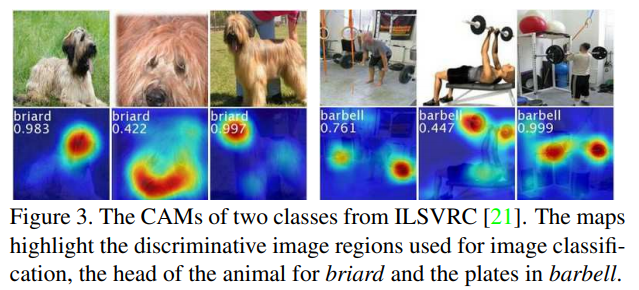


## [Grad-CAM]
- 기존 CAM의 단점은 Global Average Pooling 레이어가 필요하다는 것
- Grad-CAM은 Global Average Pooling 레이어에 의존하지 않는 아이디어
- https://sotudy.tistory.com/19

## [루브릭]
1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?
2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?
3.  인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?

In [36]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

---

## 1. 데이터 준비하기
- cars196를 사용하였다
- https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=cars196

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling cars196-train.tfrecord...:   0%|          | 0/8144 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling cars196-test.tfrecord...:   0%|          | 0/8041 [00:00<?, ? examples/s]

Dataset cars196 downloaded and prepared to /aiffel/tensorflow_datasets/cars196/2.0.1. Subsequent calls will reuse this data.


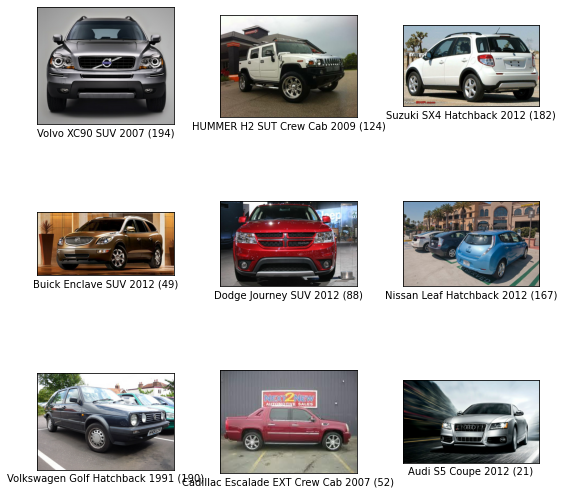

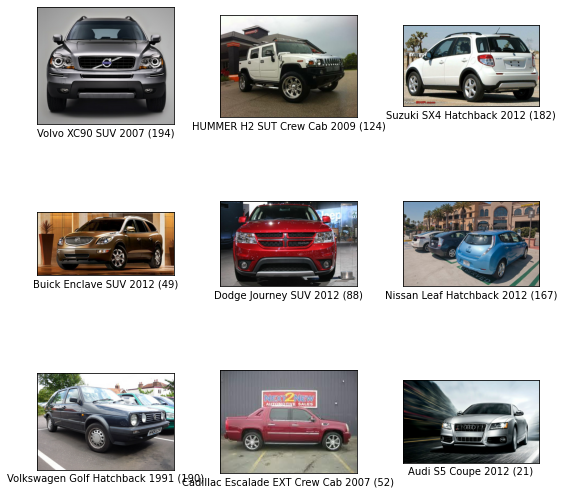

In [3]:
tfds.show_examples(ds_train, ds_info)

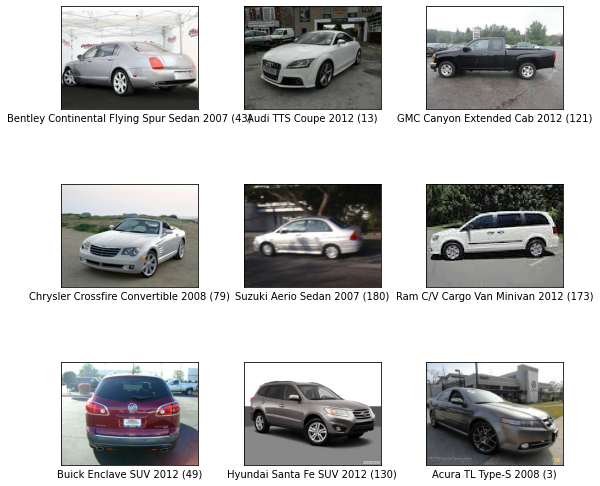

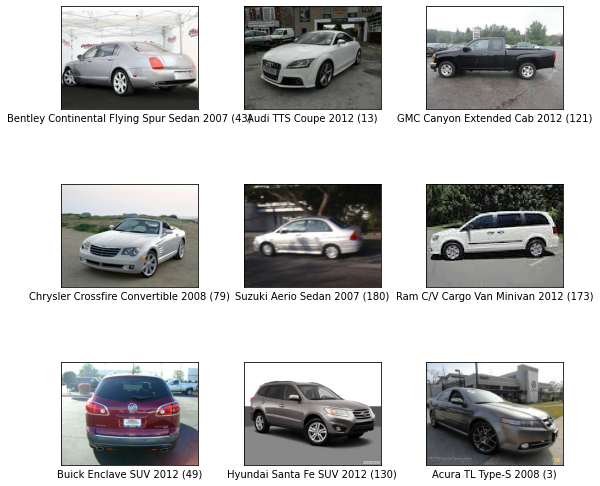

In [4]:
tfds.show_examples(ds_test, ds_info)

---

## 2. 물체의 위치정보

In [5]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

> image와 label은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스이다.  <br>
bbox 는 물체의 위치를 사각형 영역으로 표기하는 방법이다. <br> BBoxFeature이라는 타입으로 정의되어 있다

### 바운딩 박스를 표시하는 방법들
바운딩 박스를 라벨링하는 방법은 아주 다양하다. 그 중 주로 사용되는 방법은 'xywh' 또는 'minmax'로 표기하는 방법이다

- xymh : 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법
    - x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있다
- minmax : 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법이다
    - 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적
   
위 두가지 뿐만 아니라 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법, 좌우측의 x값과 상하측방법(LRTB), 네 점의 x, y 좌표 값을 모두 표시하는 방법(QUAD) 등 여러 가지 방법이의 y값 네 개로 표시하는  있다.

    

---

## 3. CAM을 위한 모델 만들기
- CAM 모델은 우리가 해왔던 분류 문제를 위한 모델과 크게 다른 점이 없다. 다만 마지막 fully connected layer 대신 `GAP`을 사용해주어야 한다. 우리의 경우 ResNet50의 매개변수 pooling에 `'avg'`를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있다.

In [6]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [7]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

---

## 4. CAM 모델 학습하기

In [8]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [10]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [11]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
509/509 [==============================] - 131s 232ms/step - loss: 4.1196 - accuracy: 0.1784 - val_loss: 5.5372 - val_accuracy: 0.0059
Epoch 2/20
509/509 [==============================] - 115s 226ms/step - loss: 1.6042 - accuracy: 0.6529 - val_loss: 2.0721 - val_accuracy: 0.4725
Epoch 3/20
509/509 [==============================] - 113s 223ms/step - loss: 0.5498 - accuracy: 0.9058 - val_loss: 1.3253 - val_accuracy: 0.6520
Epoch 4/20
509/509 [==============================] - 114s 224ms/step - loss: 0.1562 - accuracy: 0.9876 - val_loss: 1.1156 - val_accuracy: 0.7067
Epoch 5/20
509/509 [==============================] - 113s 223ms/step - loss: 0.0698 - accuracy: 0.9972 - val_loss: 1.0639 - val_accuracy: 0.7170
Epoch 6/20
509/509 [==============================] - 113s 223ms/step - loss: 0.0355 - accuracy: 0.9984 - val_loss: 1.0532 - val_accuracy: 0.7240
Epoch 7/20
509/509 [==============================] - 113s 223ms/step - loss: 0.0254 - accuracy: 0.9982 - val_loss: 1.0277 -

In [25]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


저장 완료!


---

## 5. CAM

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

29


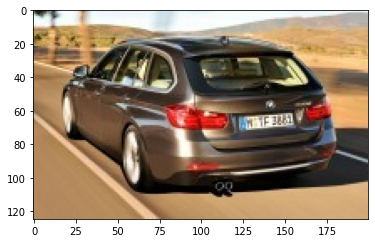

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [16]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

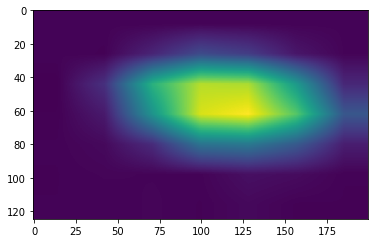

In [17]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [18]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

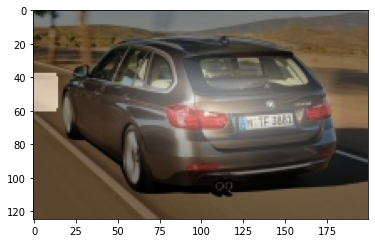

In [19]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

---

## 6. Grad_CAM

130


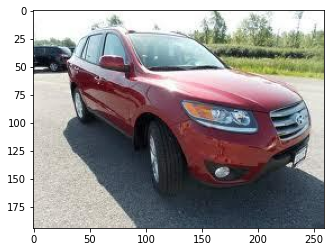

In [20]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### grad_cam
- 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구한다
- 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 된다.
- 이전 스텝에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 `activation_layer`를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 한다.

In [21]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

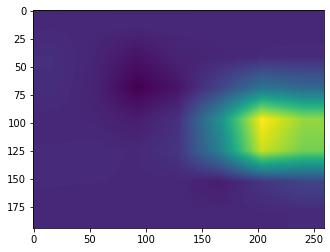

In [22]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

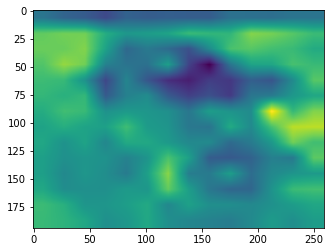

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

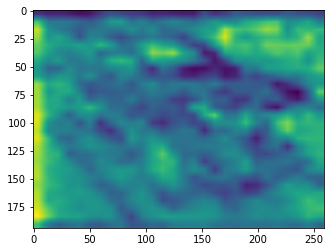

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

---

## 7. Detection with CAM

### 바운딩 박스

116


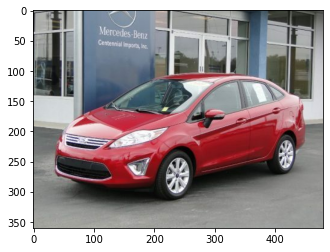

In [26]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

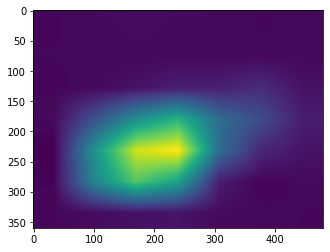

In [27]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

### get_bbox
- 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앤다.
- OpenCV의 findContours()와 minAreaRect()로 사각형을 찾는다. 
    - cv2.findContours() : 윤곽선을 검색한다.
        - 반환값으로 윤곽선, 계층 구조를 반환한다
        - 윤관선은 Numpy 구조의 배열로 검출된 윤곽선의 지점들이 담겨있다
        - https://076923.github.io/posts/Python-opencv-21/
    - cv2.minAreaRect() 
        - 입력받은 포인터들을 모두 포함하면서 최소한의 영역을 차지하는 직사각형을 찾는다
        - 이때 직사각형은 boundingRect 함수처럼 곧게 서있을 수도, 회전할 수도 있다
        - https://dsbook.tistory.com/227
- 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있다. 
- boxPoints()로 이를 꼭지점으로 바꾸어 준다. 마지막에는 int 자료형으로 변환해 준다.

In [28]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

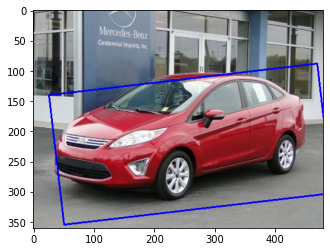

In [29]:
rect = get_bbox(cam_image)

image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection Over Union

IoU(Intersection over Union)는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값이다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다. 이를 이용해 정답 데이터인 바운딩 박스와 CAM과 Grad-CAM 두 가지 방법을 통해서 바운딩 박스를 비교, 평가할 수 있다

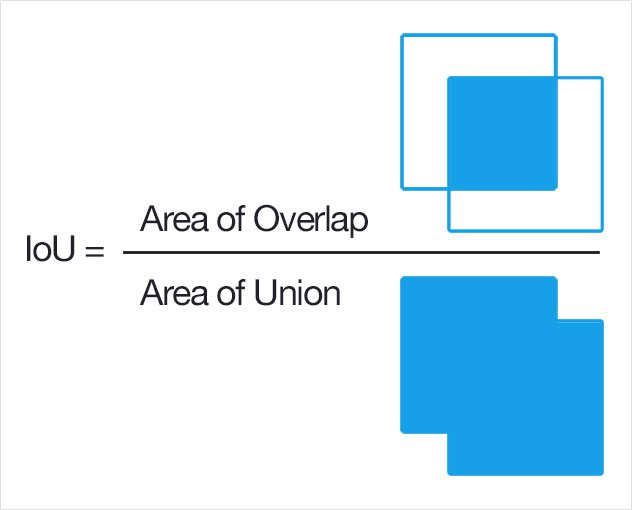

In [30]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [31]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.24444444444444444, 0.05416666666666667, 0.9833333333333333, 1.03125]

In [32]:
item['bbox']

array([0.29166666, 0.075     , 0.875     , 0.94375   ], dtype=float32)

In [33]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [35]:
get_iou(pred_bbox, item['bbox'])

0.7019415252918918

---

## 8. 비교

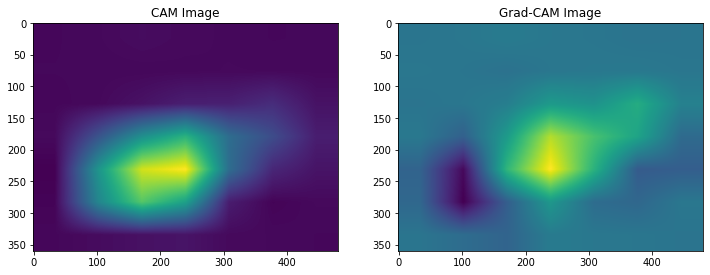

In [37]:
cam_image = generate_cam(cam_model, item)
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('CAM Image')
plt.imshow(cam_image)
plt.subplot(1, 2, 2)
plt.title('Grad-CAM Image')
plt.imshow(grad_cam_image)

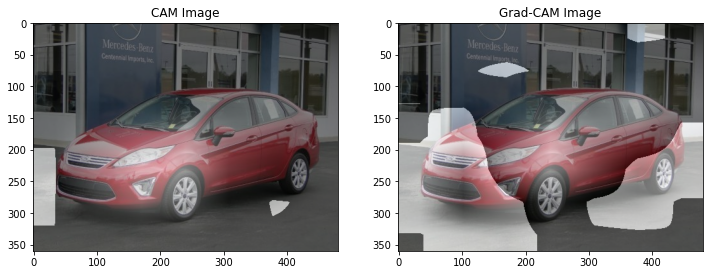

In [38]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

cam_blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('CAM Image')
plt.imshow(cam_blended_image)
plt.subplot(1, 2, 2)
plt.title('Grad-CAM Image')
plt.imshow(grad_blended_image)

In [39]:
cam_rect = get_bbox(cam_image)
grad_cam_rect = get_bbox(grad_cam_image)

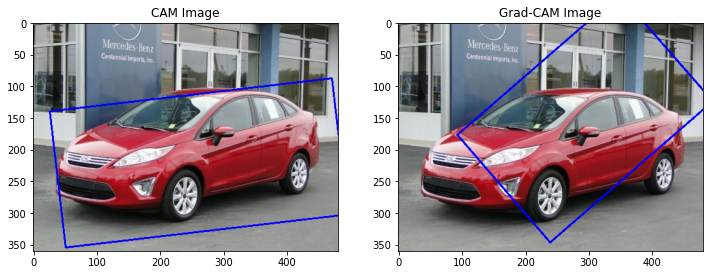

In [40]:
cam_bbox_image = cv2.drawContours(copy.deepcopy(item['image']), [cam_rect], 0, (0, 0, 255), 2)
grad_cam_bbox_image = cv2.drawContours(copy.deepcopy(item['image']), [grad_cam_rect], 0, (0, 0, 255), 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('CAM Image')
plt.imshow(cam_bbox_image)
plt.subplot(1, 2, 2)
plt.title('Grad-CAM Image')
plt.imshow(grad_cam_bbox_image)

In [41]:
cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
grad_cam_pred_bbox = rect_to_minmax(grad_cam_rect, item['image'])

In [42]:
cam_iou = get_iou(cam_pred_bbox, item['bbox'])
grad_cam_iou = get_iou(grad_cam_pred_bbox, item['bbox'])

In [43]:
print(f'CAM IoU : {cam_iou}')
print(f'Grad-CAM IoU : {grad_cam_iou}')

CAM IoU : 0.7019415252918918
Grad-CAM IoU : 0.4480000301757817


### 정리
1. CAM 방식과 Grad-CAM 방식의 class activation map을 보면 CAM방식이 object의 주요 특징 위치를 잘 반영했다. 
2. 바운딩박스를 보면 차이를 크게 볼 수 있는데, CAM의 바운딩박스가 훨씬 정확하다
3. IOU에서도 성능이 확실히 차이가 난다. 
4. 위의 결과로 CAM의 성능이 더 좋다고 말할 수 있다

---